This is the newest merge notebook.

In [1]:
import os
import time

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

import shapely
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
start_time = time.time()

In [3]:
# Load the two datasets.
path1 = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_2003_2018.csv"
path2 = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_2018_Present.csv"

dataframe1 = pd.read_csv(path1)
dataframe2 = pd.read_csv(path2)

# Only keep the columns that are of interest.
columns1 = ["Category", "DayOfWeek", "Date", "Time", "PdDistrict", "Y", "X"]
columns2 = ["Incident Date", "Incident Time", "Incident Day of Week", "Incident Category", "Incident Subcategory", "Incident Description", "Police District", "Latitude", "Longitude"]

dataframe1 = dataframe1[columns1]
dataframe2 = dataframe2[columns2]

In [4]:
# Load the centroid information.
centroids_path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_District_Centroids.csv"
centroids_dataframe = pd.read_csv(centroids_path)

# Convert the Pandas DataFrame to a GeoDataFrame.
centroids_dataframe["geometry"] = centroids_dataframe["geometry"].apply(shapely.wkt.loads)
centroids_dataframe["centroid"] = centroids_dataframe["centroid"].apply(shapely.wkt.loads)
centroids_dataframe = gpd.GeoDataFrame(centroids_dataframe, geometry="geometry")

### Dataset 1

From exploring the data, we know the following:

* There are no duplicate entries.
* There is one missing entry from the Police District column. To resolve this issue, we can assign the district by determining which police district the (latitude, longitude) point belongs to.
* There are invalid Longitude/Latitude pairs. The invalid ones have (-120.5, 90.0) as their coordinates, so they are easily identifiable. To resolve this issue, we are going to put their coordinates at the center of mass of their police district polygons.

First, let's deal with the missing police district entry.

In [5]:
# Find the coordinates of the missing entry, in (latitude, longitude) convention.
coord = dataframe1[dataframe1["PdDistrict"].isna()][["X", "Y"]].to_numpy().flatten()[::-1]
coord = shapely.geometry.point.Point(coord)

# Find the police district that this coordinate is associated with.
district_polygons = [centroids_dataframe.iloc[idx]["geometry"] for idx in range(len(centroids_dataframe))]
for idx, polygon in enumerate(district_polygons):
    if polygon.contains(coord):
        print("The associated police district is {}".format(centroids_dataframe.iloc[idx]["district"]))
    elif coord.distance(polygon) < 1e-3:
        print("The associated police district is {}".format(centroids_dataframe.iloc[idx]["district"]))

The associated police district is INGLESIDE


Something is wrong, we need to see why none of the Police districts contain the point.

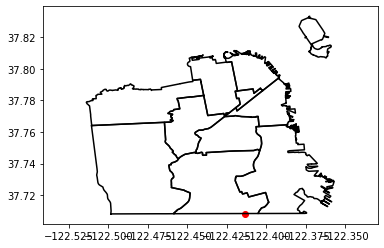

In [6]:
# Plot all of the districts and the point in question.
for polygon in district_polygons:
    plt.plot(*polygon.exterior.xy[::-1], c="black")
plt.scatter(*coord.xy[::-1], color="r")
_ = plt.axis("equal")

Indeed it looks like we actually have to sometimes check the distance between this point and the boundary of the polygon to determine which district the point approximately associates with. 

Note that 1e-3 is an arbitrary bound.

The data point with the missing police district information can be labeled as belonging to the Ingleside police district.

In [7]:
# Fill in the missing information.
index = dataframe1[dataframe1["PdDistrict"].isna()].index[0]
dataframe1.loc[index, "PdDistrict"] = "INGLESIDE"

In [8]:
# Confirm the information was inserted.
dataframe1.iloc[index]

Category      LARCENY/THEFT
DayOfWeek            Sunday
Date             01/17/2016
Time                  23:54
PdDistrict        INGLESIDE
Y                   37.7082
X                  -122.413
Name: 1775753, dtype: object

Great! The information was inserted into the DataFrame.

Now we deal with the invalid latitude/longitude pairs. The remedy for this issue is pretty simple, we will just replace them with the centroids of their associated police district.

In [9]:
def validate_coordinates(coords):
    """Determines if the location represented by the coordinates is contained within the San Francisco County bounding box.

    Parameters
    ----------
    coords : tuple (float, float)
        The coorindates in (latitude, longitude) representing the coordinates to verify.
    
    Returns
    -------
    valid : bool
        Returns ``True`` if the location is contained within the San Francisco County bounding box. Returns ``False`` otherwise.

    """
    x = coords[1]
    y = coords[0]
    if (x >= -123.173825 and x <= -122.28178) and (y >= 37.623983 and y <= 37.929824):
        return True
    else:
        return False

In [10]:
# Find the indicies of the entries that have invalid coordinates, that are outside the range of the San Francisco County bounding box.
invalid_coord_indices = list()
coordinates = dataframe1[["Y", "X"]]

for idx, row in tqdm(enumerate(coordinates.itertuples()), total=len(coordinates)):
    row = row[1:]
    valid = validate_coordinates(row)
    if valid == False:
        invalid_coord_indices.append(idx)

print("\nThere are {} invalid entries.".format(len(invalid_coord_indices)))

100%|██████████| 2160953/2160953 [00:09<00:00, 239459.14it/s]
There are 142 invalid entries.



In [11]:
# For each of the indices above, replace the coordinates with the centroids of the police districts that they represent.
for index in tqdm(invalid_coord_indices):
    police_district = dataframe1.iloc[index]["PdDistrict"].upper()
    centroid = centroids_dataframe[centroids_dataframe["district"] == police_district].iloc[0]["centroid"]
    centroid = centroid.xy
    dataframe1.loc[index, "Y"] = centroid[0][0]
    dataframe1.loc[index, "X"] = centroid[1][0]

100%|██████████| 142/142 [00:06<00:00, 22.54it/s]


In [12]:
# Confirm that the above worked.
test_index = invalid_coord_indices[0]
dataframe1.iloc[test_index]

Category      PROSTITUTION
DayOfWeek           Friday
Date            09/12/2003
Time                 23:00
PdDistrict        NORTHERN
Y                    37.79
X                 -122.432
Name: 2137, dtype: object

Looks like the above worked from a simple inspection. Let's use the Google Maps API to confirm this.

In [13]:
import gmaps

key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

gmaps.configure(api_key=api_key)

In [14]:
# Plot the Northern police district polygon
northern_entry = centroids_dataframe[centroids_dataframe["district"] == "NORTHERN"].iloc[0]
northern_polygon = northern_entry["geometry"]
northern_centroid = northern_entry["centroid"].xy
drawing_list = [gmaps.Polygon(northern_polygon.exterior.coords[:], stroke_color="black", stroke_opacity=0.2,)]
marker_list = [(northern_centroid[0][0], northern_centroid[1][0])]

fig = gmaps.figure()
drawing = gmaps.drawing_layer(drawing_list)
marker = gmaps.marker_layer(marker_list)
fig.add_layer(drawing)
fig.add_layer(marker)

fig

Figure(layout=FigureLayout(height='420px'))

Looks like the above method works from a visual inspection as well.

Next we rename and reorder the columns to ensure consistency between the two datasets. Additionally we make modifications to ensure that the data values are consistent as well. 

In [15]:
# Rename and reorder the columns.
columns1_rename = {"DayOfWeek": "Day of Week", "PdDistrict": "Police District", "X": "Longitude", "Y": "Latitude",}
columns1_reorder = ["Date", "Time", "Day of Week", "Category", "Police District", "Latitude", "Longitude"]

dataframe1.rename(columns=columns1_rename, inplace=True)
dataframe1 = dataframe1[columns1_reorder]

In [16]:
dataframe1

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,07/01/2011,08:00,Friday,WARRANTS,NORTHERN,37.802151,-122.439758
1,10/18/2005,14:30,Tuesday,DRUG/NARCOTIC,TENDERLOIN,37.779944,-122.414318
2,01/29/2005,13:45,Saturday,VEHICLE THEFT,BAYVIEW,37.737576,-122.388799
3,06/02/2011,02:52,Thursday,NON-CRIMINAL,CENTRAL,37.803109,-122.414354
4,02/01/2003,08:00,Saturday,VEHICLE THEFT,BAYVIEW,37.724556,-122.401097
...,...,...,...,...,...,...,...
2160948,07/29/2017,20:15,Saturday,LARCENY/THEFT,RICHMOND,37.782849,-122.466565
2160949,12/04/2016,21:15,Sunday,LARCENY/THEFT,NORTHERN,37.780075,-122.420250
2160950,05/14/2016,12:30,Saturday,LARCENY/THEFT,PARK,37.769660,-122.442765
2160951,07/16/2017,19:01,Sunday,ROBBERY,SOUTHERN,37.773218,-122.421522


Now we modify the data so that it is consistent with the other dataset. The modifications are the following:

* The "Date" column will contain data in the format YYYY/MM/DD.
* The "Time" column will contain data in the HH:MM format assuming military time.
* The "Day of Week" column will contain data that is in upper case.
* The "Category" column will contain data that is in upper case.
* The "Police District" column will contain data that is in upper case.
* The "Latitude" and "Longitude" columns will contain data that is of type float.

In [17]:
def convert_mdy_to_ymd(date):
    """Converts a date from the MM/DD/YYYY convention to the YYYY/MM/DD convention.

    Parameters
    ----------
    date : string
        String containing the date in the MM/DD/YYYY format.
    
    Returns
    -------
    date : string
        String containing the date in the YYYY/MM/DD format.

    """
    date = date.split("/")
    date = date[2] + "/" + date[0] + "/" + date[1]

    return date

In [18]:
# Modify the "Date" column so that the data is in the format YYYY/MM/DD.
dataframe1["Date"] = dataframe1["Date"].apply(lambda x: convert_mdy_to_ymd(x))
dataframe1["Date"]

0          2011/07/01
1          2005/10/18
2          2005/01/29
3          2011/06/02
4          2003/02/01
              ...    
2160948    2017/07/29
2160949    2016/12/04
2160950    2016/05/14
2160951    2017/07/16
2160952    2016/06/16
Name: Date, Length: 2160953, dtype: object

In [19]:
# Modify the "Day of Week" column so that the data is in upper case.
dataframe1["Day of Week"] = dataframe1["Day of Week"].apply(lambda x: x.upper())
dataframe1["Day of Week"]

0            FRIDAY
1           TUESDAY
2          SATURDAY
3          THURSDAY
4          SATURDAY
             ...   
2160948    SATURDAY
2160949      SUNDAY
2160950    SATURDAY
2160951      SUNDAY
2160952    THURSDAY
Name: Day of Week, Length: 2160953, dtype: object

In [20]:
# Modify the "Police District" column to ensure that the data is in upper case.
dataframe1["Police District"] = dataframe1["Police District"].apply(lambda x: x.upper())
dataframe1["Police District"]

0            NORTHERN
1          TENDERLOIN
2             BAYVIEW
3             CENTRAL
4             BAYVIEW
              ...    
2160948      RICHMOND
2160949      NORTHERN
2160950          PARK
2160951      SOUTHERN
2160952      SOUTHERN
Name: Police District, Length: 2160953, dtype: object

Looks like everything is good to go for the first dataset!

### Dataset 2

From exploring the data, we know the following:

* There are no duplicate entries.
* There are 267 missing entries in the Incident Category column. The majority of these incidents are Public Health Order Violations, Notification or After Notification (this is new due to the COVID-19 pandemic). To resolve this issue we are going to introduce another category called "Other", for which these incidents will fall under.
* There are 20332 invalid coordinates, taking on a value of NaN. Of these 20332, 6797 have "Out of SF" as their Police District. For the "Out of SF" entries there is no remedy but for the others we can replace the coordinates with the center of mass of their police district polygons.
* See center_of_mass.ipynb for more information on how the center of mass for each police district was computed.

Before we deal with the 267 missing entries in the "Incident Category" column let's deal with the "Out of SF" entries.

In [21]:
# Remove the "Out of SF" entries, since no information can be found on them.
out_of_sf_indices = dataframe2[dataframe2["Police District"] == "Out of SF"].index
dataframe2.drop(out_of_sf_indices, axis=0, inplace=True)
dataframe2.reset_index(drop=True, inplace=True)

In [22]:
# Verify the above.
len(dataframe2[dataframe2["Police District"] == "Out of SF"])

0

With the entries in the "Police District" that are "Out of SF" out of the way, we can deal with the 267 missing entries in the "Incident Category" column.

In [23]:
# Find the indices of the entries with missing category information, and fill them in with "OTHER".
missing_category_indices = dataframe2[dataframe2["Incident Category"].isna()].index
for index in missing_category_indices:
    dataframe2.loc[index, "Incident Category"] = "OTHER"

Let's confirm that the above works by checking the Incident Category for those indices.

In [24]:
dataframe2.iloc[missing_category_indices]

,Incident Date,Incident Time,Incident Day of Week,Incident Category,Incident Subcategory,Incident Description,Police District,Latitude,Longitude
1167,2020/08/16,00:00,Sunday,OTHER,NaN,"Public Health Order Violation, Notification",Mission,37.759830,-122.425920
1984,2020/08/22,13:49,Saturday,OTHER,NaN,"Public Health Order Violation, Notification",Mission,37.766674,-122.419825
2049,2020/08/22,13:05,Saturday,OTHER,NaN,"Public Health Order Violation, Notification",Mission,37.766674,-122.419825
2244,2020/08/23,01:40,Sunday,OTHER,NaN,"Driving, Sideshow/Street Racing",Bayview,37.743124,-122.403275
2331,2020/08/23,03:15,Sunday,OTHER,NaN,"Driving, Sideshow/Street Racing",Mission,37.769199,-122.417783
...,...,...,...,...,...,...,...,...,...
382047,2020/08/12,13:18,Wednesday,OTHER,NaN,"Public Health Order Violation, Notification",Mission,37.765051,-122.419669
382063,2020/08/12,11:52,Wednesday,OTHER,NaN,"Public Health Order Violation, Notification",Southern,37.777457,-122.413158
382487,2020/08/13,18:24,Thursday,OTHER,NaN,Military Ordinance,Mission,37.750903,-122.413926
382611,2020/08/14,07:55,Friday,OTHER,NaN,"Public Health Order Violation, Notification",Northern,37.799978,-122.442846


Entries that had NaN values for the Incident Category column have now been assigned "OTHER".

Next we deal with the invalid coordinate entries. For these invalid entries, we are going to find their associated Police District and fill in the invalid coordinates with the centroids of the district.

See center_of_mass.ipynb for more information on how the centroids are computed.

In [25]:
# Find the indices of the entries that are missing Latitude information.
invalid_coord_indices = dataframe2[dataframe2["Latitude"].isna()].index

In [26]:
# For each of these entries, replace the Latitude and Longitude information based on the centroid of the police districts.
for idx in tqdm(invalid_coord_indices):
    police_district = dataframe2.loc[idx, "Police District"].upper()
    centroid = centroids_dataframe[centroids_dataframe["district"] == police_district].iloc[0]["centroid"].xy
    dataframe2.loc[idx, "Latitude"] = centroid[0][0]
    dataframe2.loc[idx, "Longitude"] = centroid[1][0]

100%|██████████| 13535/13535 [01:41<00:00, 133.83it/s]


In [27]:
# Verify the above.
dataframe2.iloc[invalid_coord_indices]

,Incident Date,Incident Time,Incident Day of Week,Incident Category,Incident Subcategory,Incident Description,Police District,Latitude,Longitude
0,2020/08/15,09:40,Saturday,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Park,37.764349,-122.449108
1,2018/02/24,22:00,Saturday,Lost Property,Lost Property,Lost Property,Park,37.764349,-122.449108
31,2020/08/14,09:45,Friday,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Richmond,37.777605,-122.479660
64,2020/08/12,13:00,Wednesday,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Southern,37.776321,-122.398862
91,2020/08/14,15:00,Friday,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Richmond,37.777605,-122.479660
...,...,...,...,...,...,...,...,...,...
382887,2020/08/10,01:00,Monday,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Park,37.764349,-122.449108
382889,2020/08/13,03:00,Thursday,Larceny Theft,Larceny - From Vehicle,"Theft, From Unlocked Vehicle, >$950",Park,37.764349,-122.449108
382906,2020/07/28,01:00,Tuesday,Larceny Theft,Larceny - From Vehicle,"Theft, From Unlocked Vehicle, >$950",Northern,37.789985,-122.431758
382910,2020/08/14,14:00,Friday,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Taraval,37.736633,-122.481830


The entries where the latitude and longitude information have been replaced with the centroid of their corresponding police district.

Next we rename and reorder the columns to ensure consistency between the two datasets. Additionally we make modifications to ensure that the data values are consistent as well. 

In [28]:
# Rename and reorder the columns for consistency.
columns2_rename = {"Incident Date": "Date", "Incident Time": "Time", "Incident Day of Week": "Day of Week", "Incident Category": "Category"}
columns2_reorder = ["Date", "Time", "Day of Week", "Category", "Police District", "Latitude", "Longitude"]

dataframe2.rename(columns=columns2_rename, inplace=True)
dataframe2 = dataframe2[columns2_reorder]

In [29]:
# Verify the above.
dataframe2

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2020/08/15,09:40,Saturday,Larceny Theft,Park,37.764349,-122.449108
1,2018/02/24,22:00,Saturday,Lost Property,Park,37.764349,-122.449108
2,2020/08/16,03:13,Sunday,Assault,Bayview,37.754827,-122.397729
3,2020/08/16,03:38,Sunday,Malicious Mischief,Mission,37.766540,-122.422044
4,2020/08/16,13:40,Sunday,Non-Criminal,Southern,37.784044,-122.403712
...,...,...,...,...,...,...,...
383071,2020/08/15,20:44,Saturday,Larceny Theft,Central,37.788808,-122.411886
383072,2020/08/15,08:00,Saturday,Non-Criminal,Northern,37.792263,-122.436204
383073,2020/08/15,15:47,Saturday,Burglary,Central,37.788293,-122.408402
383074,2020/08/15,21:52,Saturday,Recovered Vehicle,Taraval,37.741234,-122.474494


Now we modify the data so that it is consistent with the other dataset. The modifications are the following:

* The "Date" column will contain data in the format YYYY/MM/DD.
* The "Time" column will contain data in the HH:MM format assuming military time.
* The "Day of Week" column will contain data that is in upper case.
* The "Category" column will contain data that is in upper case.
* The "Police District" column will contain data that is in upper case.
* The "Latitude" and "Longitude" columns will contain data that is of type float.

For this dataset we only need to modify the "Day of Week", "Category", and "Police District" columns.

Let's start with the "Day of Week" column.

In [30]:
# Capitalize the entire "Day of Week" column.
dataframe2["Day of Week"] = dataframe2["Day of Week"].apply(lambda x: x.upper())

In [31]:
# Capitalize the entire "Category" column.
dataframe2["Category"] = dataframe2["Category"].apply(lambda x: x.upper())

In [32]:
# Capitalize the entire "Police District" column.
dataframe2["Police District"] = dataframe2["Police District"].apply(lambda x: x.upper())

In [33]:
# Verify the results of the above.
dataframe2

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2020/08/15,09:40,SATURDAY,LARCENY THEFT,PARK,37.764349,-122.449108
1,2018/02/24,22:00,SATURDAY,LOST PROPERTY,PARK,37.764349,-122.449108
2,2020/08/16,03:13,SUNDAY,ASSAULT,BAYVIEW,37.754827,-122.397729
3,2020/08/16,03:38,SUNDAY,MALICIOUS MISCHIEF,MISSION,37.766540,-122.422044
4,2020/08/16,13:40,SUNDAY,NON-CRIMINAL,SOUTHERN,37.784044,-122.403712
...,...,...,...,...,...,...,...
383071,2020/08/15,20:44,SATURDAY,LARCENY THEFT,CENTRAL,37.788808,-122.411886
383072,2020/08/15,08:00,SATURDAY,NON-CRIMINAL,NORTHERN,37.792263,-122.436204
383073,2020/08/15,15:47,SATURDAY,BURGLARY,CENTRAL,37.788293,-122.408402
383074,2020/08/15,21:52,SATURDAY,RECOVERED VEHICLE,TARAVAL,37.741234,-122.474494


Looks like everything is good to go for the second dataset! 

Now we can move on to merging the data and ensuring that it is as clean as we can get it.

### Merging the Datasets

* In this section we merge the two datasets to create one giant dataset.

In [34]:
# Let's try a basic merge.
frames = [dataframe1, dataframe2]
dataframe = pd.concat(frames, ignore_index=False, sort=False)

# Reset the index.
dataframe.reset_index(drop=True, inplace=True)

In [35]:
# Confirm the result of the above.
dataframe

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2011/07/01,08:00,FRIDAY,WARRANTS,NORTHERN,37.802151,-122.439758
1,2005/10/18,14:30,TUESDAY,DRUG/NARCOTIC,TENDERLOIN,37.779944,-122.414318
2,2005/01/29,13:45,SATURDAY,VEHICLE THEFT,BAYVIEW,37.737576,-122.388799
3,2011/06/02,02:52,THURSDAY,NON-CRIMINAL,CENTRAL,37.803109,-122.414354
4,2003/02/01,08:00,SATURDAY,VEHICLE THEFT,BAYVIEW,37.724556,-122.401097
...,...,...,...,...,...,...,...
2544024,2020/08/15,20:44,SATURDAY,LARCENY THEFT,CENTRAL,37.788808,-122.411886
2544025,2020/08/15,08:00,SATURDAY,NON-CRIMINAL,NORTHERN,37.792263,-122.436204
2544026,2020/08/15,15:47,SATURDAY,BURGLARY,CENTRAL,37.788293,-122.408402
2544027,2020/08/15,21:52,SATURDAY,RECOVERED VEHICLE,TARAVAL,37.741234,-122.474494


Visually the merge looks good but we need to ensure that there are no missing entries and look for duplicate values, which will be removed.

First we'll remove the duplicate entries.

In [36]:
# Remove duplicate entries.
dataframe.drop_duplicates(inplace=True)
dataframe.reset_index(drop=True, inplace=True)

In [37]:
# Confirm that there are no missing entries in the "Date" column.
len(dataframe[dataframe["Date"].isna()])

0

In [38]:
# Confirm that there are no missing entries in the "Time" column.
len(dataframe[dataframe["Time"].isna()])

0

In [39]:
# Confirm that there are no missing entries in the "Day of Week" column.
len(dataframe[dataframe["Day of Week"].isna()])

0

In [40]:
# Confirm that there are no missing entries in the "Category" column.
len(dataframe[dataframe["Category"].isna()])

0

In [41]:
# Confirm that there are no missing entries in the "Police District" column.
len(dataframe[dataframe["Police District"].isna()])

0

In [42]:
# Confirm that there are no missing entries in the "Latitude" column.
len(dataframe[dataframe["Latitude"].isna()])

0

In [43]:
# Confirm that there are no missing entries in the "Longitude" column.
len(dataframe[dataframe["Longitude"].isna()])

0

There are no missing entries. The merge is successful!

Next, we save the results into a CSV file.

### Saving the DataFrame

* In this section we save the merged dataset as a CSV file that can be loaded by Pandas later.

In [44]:
path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_Full.csv"
dataframe.to_csv(path, index=False)

In [45]:
# Confirm that the file was indeed saved.
loaded_dataframe = pd.read_csv(path)
loaded_dataframe

,Date,Time,Day of Week,Category,Police District,Latitude,Longitude
0,2011/07/01,08:00,FRIDAY,WARRANTS,NORTHERN,37.802151,-122.439758
1,2005/10/18,14:30,TUESDAY,DRUG/NARCOTIC,TENDERLOIN,37.779944,-122.414318
2,2005/01/29,13:45,SATURDAY,VEHICLE THEFT,BAYVIEW,37.737576,-122.388799
3,2011/06/02,02:52,THURSDAY,NON-CRIMINAL,CENTRAL,37.803109,-122.414354
4,2003/02/01,08:00,SATURDAY,VEHICLE THEFT,BAYVIEW,37.724556,-122.401097
...,...,...,...,...,...,...,...
2364514,2020/08/15,19:05,SATURDAY,ASSAULT,TENDERLOIN,37.785790,-122.412970
2364515,2020/08/15,20:44,SATURDAY,LARCENY THEFT,CENTRAL,37.788808,-122.411886
2364516,2020/08/15,08:00,SATURDAY,NON-CRIMINAL,NORTHERN,37.792263,-122.436204
2364517,2020/08/15,21:52,SATURDAY,RECOVERED VEHICLE,TARAVAL,37.741234,-122.474494


In [46]:
end_time = time.time()

print("Entire notebook took {} seconds to execute.".format(end_time - start_time))

Entire notebook took 173.88461327552795 seconds to execute.
